In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function



from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from datetime import datetime
from packaging import version

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
def append_extension(fn):
    return (fn+".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[:class_number-2] = 1
    return target


DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat([response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T], axis=1)
#shuffle dataset
response = response.sample(frac=1)


data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "training",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw', 
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "validation",
    shuffle=True,
    batch_size = 28,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw',
)

# print(next(validation_set)[1].shape)

import tensorflow.keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def soft_acc_multi_output(y_true, y_pred):
    return K.mean(K.all(K.equal(K.cast(K.round(y_true),'int32'), K.cast(K.round(y_pred),'int32')),axis=1))


# batch = next(validation_set)
# y_true = batch[1]
# y_pred = model.predict(batch[0])
# print(soft_acc_multi_output(y_true,y_pred))
# print(soft_acc_multi_output([[1, 1. ,0. ,0.]],[[7.6873720e-01, 2.9802322e-08 ,1.7881393e-07, 1.7881393e-07]]))

1 Physical GPUs, 1 Logical GPUs
Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [3]:
base_model = DenseNet121(include_top=False, weights="imagenet", classes=5, input_shape=(224,224,3))
base_model.trainable = False

In [4]:
# for layer in base_model.layers[70:]:
#     layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation="linear")(x)
model = Model(inputs=base_model.input, outputs=preds, name = "intermediate")
model.compile(optimizer=keras.optimizers.Nadam(), loss='mse', metrics=[soft_acc_multi_output])

In [ ]:
# logdir_name = r".\tfb\logs\densenet_ordered_logit\\" + model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=14,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

history = model.fit_generator(generator=train_set,
                    epochs=50,
                    verbose=0,
                    validation_data=validation_set,
#                     validation_freq=2,
                    callbacks = [early_stopping, reduce_lr_plateau]
                    )

In [ ]:
model.summary()

In [8]:
for layer in base_model.layers[70:]:
    layer.trainable = True

model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output])
len(model.trainable_variables)

307

In [9]:
history_fine = model.fit_generator(generator=train_set,
                    epochs=100+history.epoch[-1],
#                     verbose=2,
                    validation_data=validation_set,
#                     validation_freq=2,
                    initial_epoch = history.epoch[-1],
                    callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
                    )

Epoch 24/123
16/16 [==============================] - 13s 831ms/step - loss: 0.4562 - soft_acc_multi_output: 0.4099 - val_loss: 0.5624 - val_soft_acc_multi_output: 0.3036
Epoch 25/123
16/16 [==============================] - 12s 748ms/step - loss: 0.3704 - soft_acc_multi_output: 0.5184 - val_loss: 1.8438 - val_soft_acc_multi_output: 0.1786
Epoch 26/123
16/16 [==============================] - 12s 747ms/step - loss: 0.2984 - soft_acc_multi_output: 0.5683 - val_loss: 4.3270 - val_soft_acc_multi_output: 0.1607
Epoch 27/123
16/16 [==============================] - 12s 746ms/step - loss: 0.2749 - soft_acc_multi_output: 0.6102 - val_loss: 4.6774 - val_soft_acc_multi_output: 0.1786
Epoch 28/123
16/16 [==============================] - 12s 741ms/step - loss: 0.2908 - soft_acc_multi_output: 0.6097 - val_loss: 4.8307 - val_soft_acc_multi_output: 0.1786
Epoch 29/123
16/16 [==============================] - 12s 756ms/step - loss: 0.2440 - soft_acc_multi_output: 0.6530 - val_loss: 2.6322 - val_soft

tf.Tensor(0.53571427, shape=(), dtype=float32)


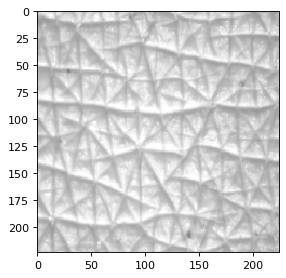

true label: [0 0 0 0]; rounded pred: [[0. 0. 0. 0.]]


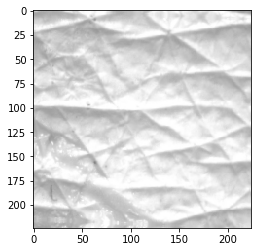

true label: [1 1 0 0]; rounded pred: [[0.98354536 0.9222272  0.05463848 0.27290606]]


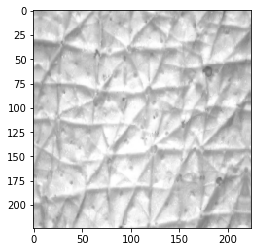

true label: [0 0 0 0]; rounded pred: [[0.9304553  0.4266009  0.00387466 0.03236282]]


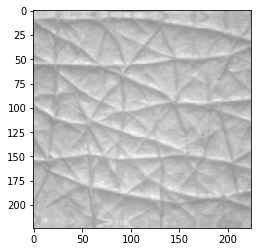

true label: [0 0 0 0]; rounded pred: [[0.03865886 0.18892369 0.00125018 0.0003379 ]]


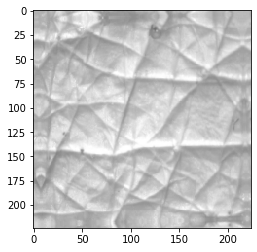

true label: [1 1 0 0]; rounded pred: [[0.944174   0.97566    0.00790724 0.0508213 ]]


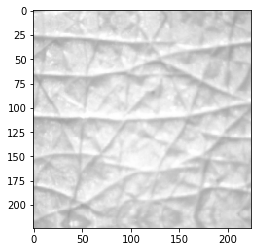

true label: [1 0 0 0]; rounded pred: [[0.98769665 0.98424083 0.02317595 0.03072295]]


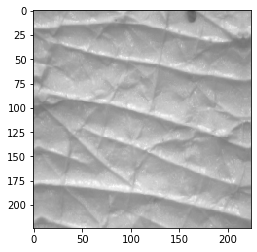

true label: [1 1 0 0]; rounded pred: [[9.9917996e-01 9.9999917e-01 9.9999309e-01 1.3709068e-06]]


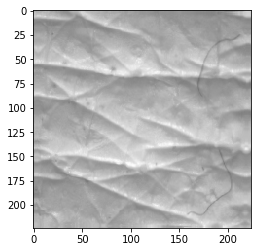

true label: [1 1 0 0]; rounded pred: [[0.9971279  0.99992836 0.9089803  0.01734614]]


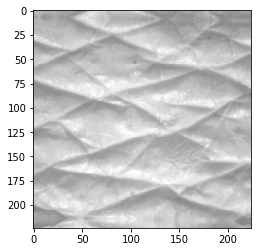

true label: [1 1 0 0]; rounded pred: [[0.9767984  0.988157   0.07558021 0.02839658]]


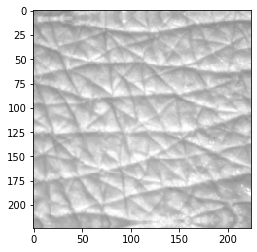

true label: [0 0 0 0]; rounded pred: [[1.1712313e-03 1.3840795e-03 2.9543042e-04 1.2993813e-05]]


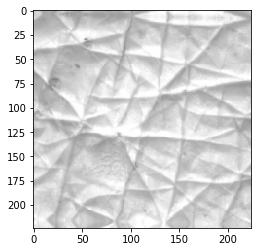

true label: [1 1 0 0]; rounded pred: [[0.978073   0.96418405 0.00186408 0.09170818]]


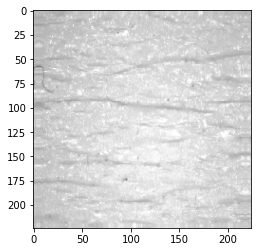

true label: [1 1 1 1]; rounded pred: [[0.9995321  0.9999998  0.9999988  0.54385847]]


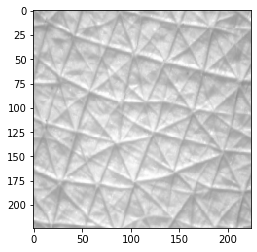

true label: [0 0 0 0]; rounded pred: [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1920929e-07]]


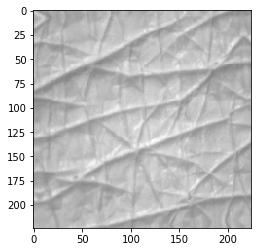

true label: [1 1 0 0]; rounded pred: [[0.991542   0.9833689  0.01239961 0.01343921]]


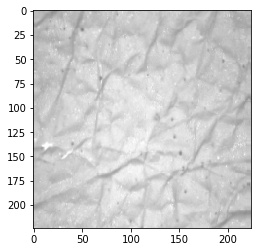

true label: [1 1 1 1]; rounded pred: [[0.9985976  0.9998547  0.98465896 0.98464066]]


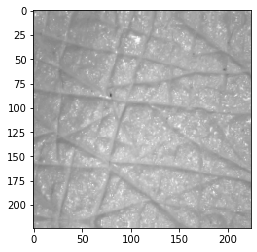

true label: [1 1 0 0]; rounded pred: [[0.8910733  0.9996152  0.99550045 0.00107774]]


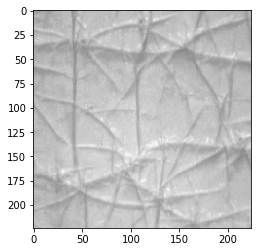

true label: [1 1 0 0]; rounded pred: [[0.37724045 0.60812074 0.00114048 0.01821336]]


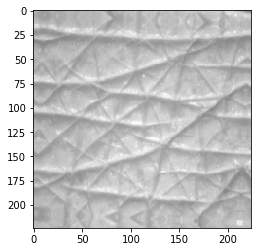

true label: [1 1 0 0]; rounded pred: [[0.5030927  0.8818362  0.04478779 0.00170693]]


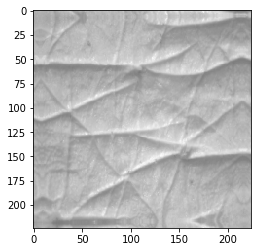

true label: [1 0 0 0]; rounded pred: [[0.9880069  0.99989134 0.42091498 0.03350168]]


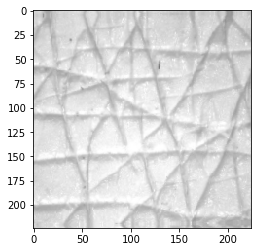

true label: [1 0 0 0]; rounded pred: [[0.07163665 0.14751658 0.0002315  0.00654149]]


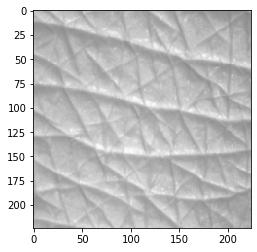

true label: [0 0 0 0]; rounded pred: [[4.9264967e-02 5.9220636e-01 9.0321004e-03 9.2983246e-06]]


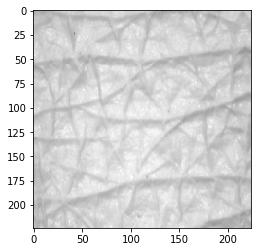

true label: [1 0 0 0]; rounded pred: [[0.69921416 0.37010407 0.02630132 0.15298027]]


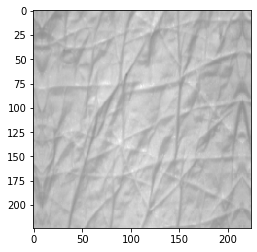

true label: [1 1 1 0]; rounded pred: [[0.9911189  0.9903411  0.00414196 0.02516824]]


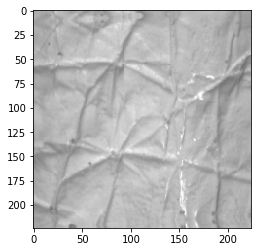

true label: [1 1 1 1]; rounded pred: [[0.9598246  0.998922   0.28336072 0.62310433]]


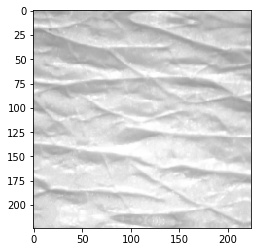

true label: [1 1 1 0]; rounded pred: [[0.9955468  0.99906904 0.06809577 0.01786408]]


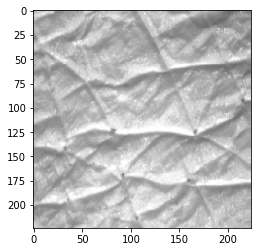

true label: [1 1 0 0]; rounded pred: [[0.98747694 0.9930449  0.04264155 0.17466411]]


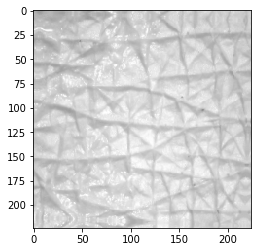

true label: [0 0 0 0]; rounded pred: [[0.56265384 0.16896164 0.00522566 0.03446203]]


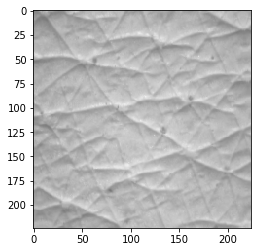

true label: [1 1 0 0]; rounded pred: [[0.9932943  0.99792266 0.00367725 0.00171661]]


In [11]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {model.predict(img.reshape(-1,224, 224, 3))}")